In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00


# Importação de Bibliotecas

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from lightgbm import early_stopping

from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt

from AleFuncoes import CortaIntervalosQuasiUniforme
from AleFuncoes import CortaIntervalosGanhoInformacao

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = pd.errors.SettingWithCopyWarning)

# Split Conjunto Treino/Teste

In [3]:
alvo = 'Churn'
df_tot = pd.read_csv('telco-customer-churn-real.zip', dtype = {'SeniorCitizen': str})
df_tot[alvo] = df_tot[alvo].map({'Yes': 1, 'No': 0})
df_tot.loc[df_tot['TotalCharges'] == ' ', 'TotalCharges'] = -1
df_tot['TotalCharges'] = df_tot['TotalCharges'].astype(float)

In [4]:
df_teste = df_tot.sample(frac = 0.5, random_state = 42)
df = df_tot[~df_tot.index.isin(df_teste.index)]

In [5]:
display(display(df_tot[['Partner', alvo]].groupby('Partner').agg(['count', 'mean'])))

Churn          
        count      mean
Partner                
No       1831  0.320590
Yes      1690  0.198817

None

# Tratamento de Features

In [6]:
colunas_id = ['customerID']
features_categoricas = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling',
                        'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                        'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
features_numericas = ['tenure', 'MonthlyCharges', 'TotalCharges']

In [7]:
dict_dummies = {'Partner': ['No']}
for f in [v for v in features_categoricas if v != 'Partner']:
    lista_dummies = list(df[f].value_counts().index[:-1])
    dict_dummies[f] = lista_dummies

for k,v in dict_dummies.items():
    for value in v:
        df[k + '_' + value] = (df[k] == value).astype(int)
        df_teste[k + '_' + value] = (df_teste[k] == value).astype(int)
    df.drop(k, axis = 1, inplace = True)
    df_teste.drop(k, axis = 1, inplace = True)
df.columns = [c.replace(' ', '_') for c in df.columns]
df_teste.columns = [c.replace(' ', '_') for c in df_teste.columns]

In [8]:
features = [v for v in df.columns if v not in colunas_id and v != alvo]

# Treinamentos

In [9]:
treinar_arvore = False
usar_teste_treinamento = False #Simula vazamento de informação

In [10]:
def funcao_de_treinamento(frac):
    #Simula treinar com uma amostra da base
    df_train = df.sample(frac = frac, random_state = 42)

    X = df_train[features]
    y = df_train[alvo].astype(int)

    if treinar_arvore:
        clf = DecisionTreeClassifier(random_state = 42)
        param_grid = {
            "max_depth": [1],
        }
    else:
        clf = LGBMClassifier(
                            objective = 'binary',
                            boosting_type = 'gbdt',
                            force_row_wise = True,
                            random_state = 42,
                            n_jobs = -1,
                            verbose = -1
                            )
        #Espaço de busca
        param_grid = {
            "n_estimators": [10, 20],
            #"n_estimators": [10, 20, 550, 100, 1000, 1250, 1500, 2500],
            "learning_rate": [0.03, 0.1],
            #"learning_rate": [0.01, 0.03, 0.1],
            "max_depth": [2, 4, 6],
            #"max_depth": [1, 2, 4, 6],
        }

    if usar_teste_treinamento:
        X_concat = np.vstack([X, X, df_teste[features]])
        y_concat = np.hstack([y, y, df_teste[alvo]])
        test_fold = [-1]*len(X) + [0]*len(X) + [1]*len(df_teste)
        cv = PredefinedSplit(test_fold)
    else:
        cv = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42)

    #Métricas: usamos roc_auc como métrica principal para refit
    grid = GridSearchCV(
            estimator = clf,
            param_grid = param_grid,
            scoring = {'roc_auc': 'roc_auc'},
            refit = 'roc_auc',
            cv = cv,
            n_jobs = -1,
            verbose = 1
        )

    if usar_teste_treinamento:
        grid.fit(X_concat, y_concat)
    else:
        grid.fit(X, y)

    #Modelo final já vem refit com os melhores hiperparâmetros
    best_model = grid.best_estimator_

    probs = best_model.predict_proba(X)[:, 1]

    df_metrics_treino = pd.DataFrame([[roc_auc_score(y, probs), ks_2samp(probs[y == 0], probs[y == 1]).statistic]],
                                    columns = ['AUC', 'KS'],
                                    index = ['Treino'])

    X_teste = df_teste[features]
    y_teste = df_teste[alvo]

    probs_teste = best_model.predict_proba(X_teste)[:, 1]

    df_metrics_teste = pd.DataFrame([[roc_auc_score(y_teste, probs_teste), ks_2samp(probs_teste[y_teste == 0], probs_teste[y_teste == 1]).statistic]],
                                    columns = ['AUC', 'KS'],
                                    index = ['Teste'])

    df_resumo = pd.concat([df_metrics_treino, df_metrics_teste])
    df_resumo['Frac'] = frac
    return df_resumo

In [11]:
lista_df_resumo = []
for frac in np.arange(0.05, 1 + 0.05, 0.05):
    df_resumo = funcao_de_treinamento(frac)
    display(df_resumo)
    lista_df_resumo.append(df_resumo)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


,AUC,KS,Frac
Treino,0.911012,0.709524,0.05
Teste,0.773950,0.431638,0.05


Fitting 4 folds for each of 12 candidates, totalling 48 fits


,AUC,KS,Frac
Treino,0.847627,0.516129,0.1
Teste,0.739798,0.425082,0.1


Fitting 4 folds for each of 12 candidates, totalling 48 fits


,AUC,KS,Frac
Treino,0.870334,0.621528,0.15
Teste,0.775838,0.433787,0.15


Fitting 4 folds for each of 12 candidates, totalling 48 fits


,AUC,KS,Frac
Treino,0.873843,0.569962,0.2
Teste,0.764465,0.400794,0.2


Fitting 4 folds for each of 12 candidates, totalling 48 fits


,AUC,KS,Frac
Treino,0.914461,0.705071,0.25
Teste,0.798766,0.469529,0.25


Fitting 4 folds for each of 12 candidates, totalling 48 fits


,AUC,KS,Frac
Treino,0.857318,0.555744,0.3
Teste,0.809289,0.483559,0.3


Fitting 4 folds for each of 12 candidates, totalling 48 fits


,AUC,KS,Frac
Treino,0.849875,0.548780,0.35
Teste,0.824689,0.496829,0.35


Fitting 4 folds for each of 12 candidates, totalling 48 fits


,AUC,KS,Frac
Treino,0.835533,0.529070,0.4
Teste,0.835810,0.528174,0.4


Fitting 4 folds for each of 12 candidates, totalling 48 fits


,AUC,KS,Frac
Treino,0.840255,0.53408,0.45
Teste,0.833645,0.52442,0.45


Fitting 4 folds for each of 12 candidates, totalling 48 fits


,AUC,KS,Frac
Treino,0.894562,0.656493,0.5
Teste,0.826902,0.506335,0.5


Fitting 4 folds for each of 12 candidates, totalling 48 fits


,AUC,KS,Frac
Treino,0.892994,0.638540,0.55
Teste,0.828621,0.498014,0.55


Fitting 4 folds for each of 12 candidates, totalling 48 fits


,AUC,KS,Frac
Treino,0.884488,0.604213,0.6
Teste,0.829579,0.498632,0.6


Fitting 4 folds for each of 12 candidates, totalling 48 fits


,AUC,KS,Frac
Treino,0.834835,0.504908,0.65
Teste,0.835074,0.518147,0.65


Fitting 4 folds for each of 12 candidates, totalling 48 fits


,AUC,KS,Frac
Treino,0.833045,0.509889,0.7
Teste,0.831980,0.531311,0.7


Fitting 4 folds for each of 12 candidates, totalling 48 fits


,AUC,KS,Frac
Treino,0.830454,0.496806,0.75
Teste,0.829933,0.521546,0.75


Fitting 4 folds for each of 12 candidates, totalling 48 fits


,AUC,KS,Frac
Treino,0.833881,0.509708,0.8
Teste,0.831580,0.518299,0.8


Fitting 4 folds for each of 12 candidates, totalling 48 fits


,AUC,KS,Frac
Treino,0.832240,0.508185,0.85
Teste,0.831143,0.508922,0.85


Fitting 4 folds for each of 12 candidates, totalling 48 fits


,AUC,KS,Frac
Treino,0.873779,0.597507,0.9
Teste,0.833823,0.522427,0.9


Fitting 4 folds for each of 12 candidates, totalling 48 fits


,AUC,KS,Frac
Treino,0.863289,0.570218,0.95
Teste,0.832883,0.522607,0.95


Fitting 4 folds for each of 12 candidates, totalling 48 fits


,AUC,KS,Frac
Treino,0.876491,0.599447,1.0
Teste,0.835490,0.525204,1.0


# Análise de Comportamento por Fração da Base de Treino

In [12]:
df_resumo_tot = pd.concat(lista_df_resumo)
df_resumo_tot = df_resumo_tot.reset_index()
df_resumo_tot = df_resumo_tot[['index', 'Frac', 'AUC', 'KS']].rename({'index': 'Conjunto'}, axis = 1)

In [13]:
def plot_metric(df: pd.DataFrame, metric: str, ylim=None):
    """
    Plota a métrica (AUC ou KS) por Frac para Treino e Teste.
    - df precisa ter colunas: Conjunto ('Treino'/'Teste'), Frac, e a métrica.
    - ylim: tupla (ymin, ymax) opcional para ajustar o eixo Y.
    """
    # Garantir tipos corretos e ordenar por Frac
    work = df.copy()
    work["Frac"] = work["Frac"].astype(float)
    work = work.sort_values("Frac")

    # Pivotar: linhas = Frac, colunas = Conjunto, valores = métrica
    wide = work.pivot(index="Frac", columns="Conjunto", values=metric)
    # Manter ordem Treino / Teste se ambas existirem
    cols = [c for c in ["Treino", "Teste"] if c in wide.columns]
    wide = wide[cols]

    # Cria a figura (um gráfico por chamada)
    plt.figure(figsize=(9, 5.5))
    # Linhas com marcadores (sem escolher cores explicitamente)
    for col in cols:
        plt.plot(wide.index, wide[col], marker="o", linewidth=2, markersize=6, label=col)

    # Rótulos e aparência
    plt.title(f"Evolução do {metric} em função da fração da base de treinamento", fontsize=12)
    plt.xlabel("Fração da base de treinamento (Frac)")
    plt.ylabel(metric)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.grid(True, alpha=0.3)
    plt.legend(title="Conjunto", frameon=False)
    plt.tight_layout()

    # Anotação de tendência no TESTE (se existir)
    if "Teste" in wide.columns and wide["Teste"].notna().sum() >= 2:
        x = wide.index.values.astype(float)
        y = wide["Teste"].values.astype(float)
        # Ajuste linear simples para inferir tendência
        slope = np.polyfit(x, y, 1)[0]
        # Posição bacana para anotação
        xy = (x[-1], y[-1])
        xytext = (x[max(1, len(x)//2)] if len(x) > 2 else x[0], np.nanmin(y) + 0.02)
        texto = "Mais dados → tendência de melhora no Teste" if slope > 0 else "Tendência no Teste"
        plt.annotate(
            texto,
            xy=xy, xytext=xytext,
            arrowprops=dict(arrowstyle="->", lw=1),
            fontsize=9
        )

    plt.show()

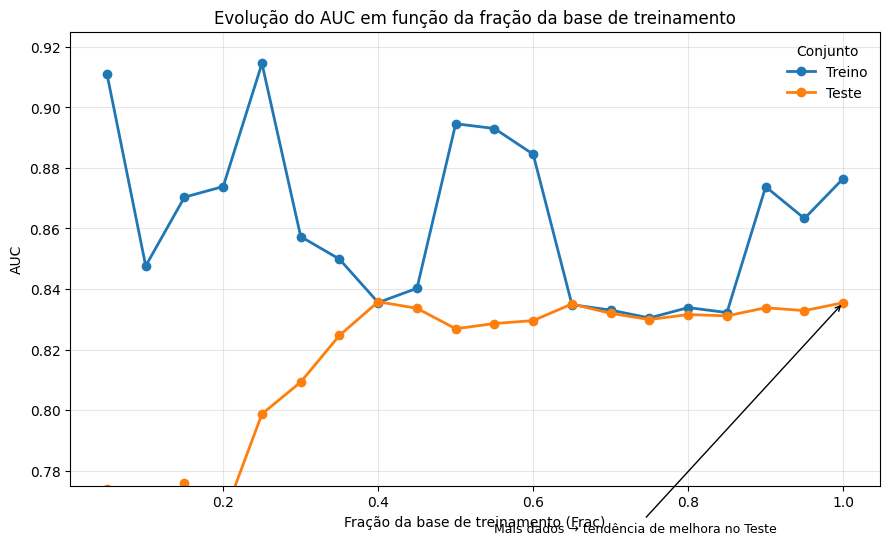

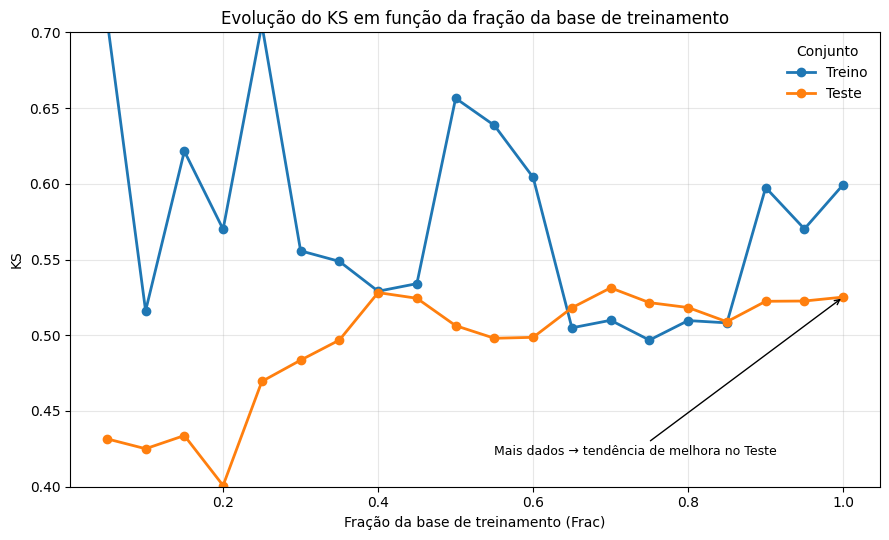

In [14]:
plot_metric(df_resumo_tot, metric="AUC", ylim=(0.775, 0.925))  # intervalo típico para AUC
print('')
plot_metric(df_resumo_tot, metric="KS",  ylim=(0.4, 0.7))  # KS varia de 0 a 1